# **AP157 Module C Lab Assignment**

## Module C2: Monte Carlo Methods

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.

_Credits_: This lab assignment is based on work by Dr. Reyes in collaboration with Gene Belinario and Dr. Reginald Bernardo.

### Student Information

_Full Name (Last Name, First Name)_: Ma. Ezthelia Kaye B. Camit \
_Student No._: 2020-06594\
_Section_:

### Submission Information

_Date and Time Submitted (most recent upload)_:

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name: MA. EZTHELIA KAYE B. CAMIT**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/20
* Part 3 - []/30
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In this lab assignment, you will generate constraints on cosmological parameters, the Hubble parameter H_0 and matter density Omega_m,0, from (synthetic) Hubble diagram data points from gravitational-wave (GW) sirens observed from 3 GW observatories: LIGO, LISA, and Einstein Telescope (ET).

The datasets are in the Google Drive "Datasets" Folder under "AP157_moduleC2" subfolder: https://drive.google.com/drive/folders/1UnK1AggxdsjtG3PoOcyXfpahBcWjOBzj?usp=drive_link.

Read in the 3 datasets from the CSV files: LIGO.csv, LISA.csv, ET.csv. The columns are redshift (z), luminosity distance (dL), and error in the luminosity distance (err). The distances are in units of Gpc (giga-parsecs).

Load the data into variable names: zLIGO, dLLIGO, errLIGO, zLISA, dLLISA, errLISA, and zET, dLET, and errET, respectively. Note that these variable names will be used in later parts of the code, so you have to use these names for compatibility.

In [13]:
import pandas as pd

# Read LIGO dataset
LIGO_data = pd.read_csv(r"C:\Users\Slim 3\Desktop\AP157\LIGO.csv")
zLIGO = LIGO_data['zLIGO']
dLLIGO = LIGO_data['dlLIGO']
errLIGO = LIGO_data['errLIGO']

# Read LISA dataset
LISA_data = pd.read_csv(r"C:\Users\Slim 3\Desktop\AP157\LISA.csv")
zLISA = LISA_data['zLISA']
dLLISA = LISA_data['dlLISA']
errLISA = LISA_data['errLISA']

# Read ET dataset
ET_data = pd.read_csv(r"C:\Users\Slim 3\Desktop\AP157\ET.csv")
zET = ET_data['zET']
dLET = ET_data['dlET']
errET = ET_data['errET']

In [15]:
print(LIGO_data.columns)

Index(['zLIGO', 'dlLIGO', 'errLIGO'], dtype='object')


By the end of the lab assignment, you will generate constraints on the cosmological parameters H_0 and omega_m,0 for 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET (combined). You will generate a corner plot to visualize these constraints similar to the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

#### PART 1 - Generate Hubble Diagram *(20 points)*

Make a Hubble diagram plot-- with luminosity distance (d_L) in the vertical axis and redshift (z) in the horizontal axis. Show the errors in d_L as error bars.

Plot GW sirens from the 3 observatories in the same plot and include a legend. Briefly describe the difference between the samples from the 3 observatories.

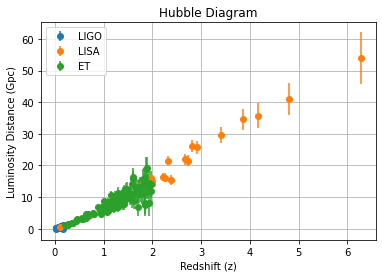

In [16]:
import matplotlib.pyplot as plt

# Plot LIGO data
plt.errorbar(zLIGO, dLLIGO, yerr=errLIGO, fmt='o', label='LIGO')

# Plot LISA data
plt.errorbar(zLISA, dLLISA, yerr=errLISA, fmt='o', label='LISA')

# Plot ET data
plt.errorbar(zET, dLET, yerr=errET, fmt='o', label='ET')

# Set labels and title
plt.xlabel('Redshift (z)')
plt.ylabel('Luminosity Distance (Gpc)')
plt.title('Hubble Diagram')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


#### PART 2 - Define likelihood functions *(20 points)*

In this analysis, we will assume the cosmological model to be flat LambdaCDM universe. This is given by the `FlatLambdaCDM' model from the astropy.cosmology package. In particular, we use the model for the luminosity distance as a function of redshift, which is encoded in the luminosity_distance function.

Below, define the chi-square and likelihood function to be used for the LIGO only and the LIGO+LISA dataset. You are asked to define the analogous functions for the LIGO+LISA+ET dataset. Note that the likelihood for the combined dataset is simply the sum of the likelihoods for the individual datasets.




In [17]:
from astropy.cosmology import FlatLambdaCDM

In [18]:
def chi2LIGO_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)      # define cosmological model
    model = np.array(cosmo.luminosity_distance(zLIGO)/1000) # converted from Gpc to Mpc units
    dev = (model - np.array(dlLIGO))/np.array(errLIGO)      # deviations between model and data
    chi2 = sum(dev**2)
    return chi2

def llikeLIGO_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf                        # return inf if outside priors
    else:
        return -0.5*chi2LIGO_lcdm(H0, Om0)

# LIGO + LISA
def chi2LISA_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zLISA)/1000)
    dev = (model - np.array(dlLISA))/np.array(errLISA)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISA_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0))

# LIGO + LISA + ET
def chi2ET_lcdm(H0, Om0):
    # insert code here

def llikeLIGOLISAET_lcdm(H0, Om0):
    # insert code here

IndentationError: expected an indented block (1719427456.py, line 32)

#### PART 3 - Perform MCMC runs *(30 points)*

Use the emcee library to set up and perform MCMC runs for the 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET combined.

You can use number of walkers (nwalkers) of 6 and number of iterations (niter) of 5,000 and number of burn-in samples (nburn) of 100.


In [20]:
import emcee
import numpy as np

# Define log likelihood function
def log_likelihood(theta, z, dL, err):
    H0, Omega_m = theta
    dL_theory = cosmological_model(H0, Omega_m, z)  # Define your cosmological model function
    sigma2 = err**2
    return -0.5 * np.sum((dL - dL_theory)**2 / sigma2 + np.log(sigma2))

# Define log prior function
def log_prior(theta):
    H0, Omega_m = theta
    if 0 < H0 < 200 and 0 < Omega_m < 1:
        return 0.0
    return -np.inf

# Define log posterior function
def log_posterior(theta, z, dL, err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, dL, err)

# Define cosmological model function
def cosmological_model(H0, Omega_m, z):
    # Define your cosmological model here (e.g., luminosity distance calculation)
    pass

# Define initial parameter values and number of parameters
initial_guess = [70, 0.3]  # Initial guess for H0 and Omega_m
ndim = len(initial_guess)

# Define number of walkers, iterations, and burn-in
nwalkers = 6
niter = 5000
nburn = 100

# Initialize walkers
pos = [initial_guess + 1e-4*np.random.randn(ndim) for _ in range(nwalkers)]

# Define data for each sample (LIGO only, LIGO+LISA, LIGO+LISA+ET)
data_samples = [(zLIGO, dLLIGO, errLIGO), (zLIGO + zLISA, dLLIGO + dLLISA, np.sqrt(errLIGO**2 + errLISA**2)), (zLIGO + zLISA + zET, dLLIGO + dLLISA + dLET, np.sqrt(errLIGO**2 + errLISA**2 + errET**2))]

# Perform MCMC runs for each sample
sampler_results = []
for data in data_samples:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=data)
    sampler.run_mcmc(pos, niter, progress=True)
    samples = sampler.get_chain(discard=nburn, thin=15, flat=True)  # Discard burn-in and thin samples
    sampler_results.append(samples)

# Access the MCMC samples for each sample if needed
samples_LIGO_only, samples_LIGO_LISA, samples_LIGO_LISA_ET = sampler_results


emcee: Exception while calling your likelihood function:
  params: [70.00013659  0.29993522]
  args: (0     0.033270
1     0.106210
2     0.073820
3     0.047333
4     0.113966
        ...   
95    0.140751
96    0.170735
97    0.073560
98    0.113640
99    0.030374
Name: zLIGO, Length: 100, dtype: float64, 0     0.101250
1     0.698621
2     0.338016
3     0.206075
4     0.401371
        ...   
95    0.607664
96    1.064420
97    0.278404
98    0.456064
99    0.081270
Name: dlLIGO, Length: 100, dtype: float64, 0     0.026146
1     0.137968
2     0.067550
3     0.034506
4     0.159718
        ...   
95    0.249926
96    0.380081
97    0.067117
98    0.158766
99    0.025129
Name: errLIGO, Length: 100, dtype: float64)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\Slim 3\anaconda3\lib\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\Slim 3\AppData\Local\Temp\ipykernel_13716\3515866776.py", line 23, in log_posterior
    return lp + log_likelihood(theta, z, dL, err)
  File "C:\Users\Slim 3\AppData\Local\Temp\ipykernel_13716\3515866776.py", line 9, in log_likelihood
    return -0.5 * np.sum((dL - dL_theory)**2 / sigma2 + np.log(sigma2))
  File "C:\Users\Slim 3\anaconda3\lib\site-packages\pandas\core\ops\common.py", line 70, in new_method
    return method(self, other)
  File "C:\Users\Slim 3\anaconda3\lib\site-packages\pandas\core\arraylike.py", line 108, in __sub__
    return self._arith_method(other, operator.sub)
  File "C:\Users\Slim 3\anaconda3\lib\site-packages\pandas\core\series.py", line 5639, in _arith_method
    return base.IndexOpsMixin._arith_method(self, other, op)
  File "C:\Users\Slim 3\anaconda3\lib\site-packag

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

#### PART 4 - Generate corner plot to visualize the constraints *(30 points)*

Overlay the results for the 3 samples for easy comparison. Your plot should resemble the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

Briefly describe the difference between the constraints obtained from the different samples.